# Gett: Failed Order Analysis 🚕

Alright, let's dig into this Gett data. The goal is to figure out why orders are failing. I've got a couple of CSVs (`data_orders` and `data_offers`) and a PDF with some questions.

My plan is to load the data, merge it, and then go through the questions one by one. Let's see what we find.

### Part 1: Setup & Loading

First, I need to import the usual libraries. Pandas and NumPy for data wrangling, Matplotlib and Seaborn for plotting. I'll also add a few settings to make the plots look a bit nicer and suppress annoying warnings.

In [26]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Ignore minor warnings to keep the output clean
warnings.filterwarnings('ignore')

# Set a nice visual style for our plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


### Part 2: Load and Inspect

Now to load the CSVs. I'll do a quick `.head()` and `.info()` on each one to see what we're working with. Always good to check for data types and nulls right at the start.

In [27]:
# --- Load Datasets ---
!wget -O data_orders.csv 'https://raw.githubusercontent.com/ChetanParmarHQ/Gett-Failed-Order-Analysis/main/data_orders.csv'
!wget -O data_offers.csv 'https://raw.githubusercontent.com/ChetanParmarHQ/Gett-Failed-Order-Analysis/main/data_offers.csv'

import pandas as pd

# --- Load CSV files safely ---
try:
    orders_df = pd.read_csv('data_orders.csv')
    offers_df = pd.read_csv('data_offers.csv')
    print("✅ Data loaded successfully.")
except FileNotFoundError:
    print("❌ ERROR: Make sure 'data_orders.csv' and 'data_offers.csv' are in the correct folder.")
except pd.errors.ParserError as e:
    print("❌ ParserError:", e)

# --- Inspect Orders Data ---
print("\n=== Orders Dataset (Top 5 Rows) ===")
print(orders_df.head())

print("\n=== Orders Dataset Info ===")
orders_df.info()

# --- Inspect Offers Data ---
print("\n=== Offers Dataset (Top 5 Rows) ===")
print(offers_df.head())

print("\n=== Offers Dataset Info ===")
offers_df.info()


--2025-11-12 05:16:03--  https://raw.githubusercontent.com/ChetanParmarHQ/Gett-Failed-Order-Analysis/main/data_orders.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571785 (558K) [text/plain]
Saving to: ‘data_orders.csv’

data_orders.csv     100%[===================>] 558.38K  --.-KB/s    in 0.04s   

2025-11-12 05:16:04 (14.0 MB/s) - ‘data_orders.csv’ saved [571785/571785]

--2025-11-12 05:16:04--  https://raw.githubusercontent.com/ChetanParmarHQ/Gett-Failed-Order-Analysis/main/data_offers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response..

### Part 3: Preprocessing

Okay, the data looks pretty clean. `order_datetime` is an `object` (string), so I'll definitely need to convert that to a real datetime.

The questions are all about hourly trends, so I'll create a new `order_hour` column right away. I'll also do a quick check for duplicates, just in case.

In [28]:
# Convert 'order_datetime' to a datetime object
orders_df['order_datetime'] = pd.to_datetime(orders_df['order_datetime'])

# Extract the hour of the day to create a new 'order_hour' column
orders_df['order_hour'] = orders_df['order_datetime'].dt.hour

# Check for missing values
print("\n=== Missing Values Check ===")
print("Orders missing values:\n", orders_df.isnull().sum())
print("\nOffers missing values:\n", offers_df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate orders found: {orders_df.duplicated().sum()}")
print(f"Duplicate offers found: {offers_df.duplicated().sum()}")

print("\nPreprocessing complete. 'order_hour' column added.")


=== Missing Values Check ===
Orders missing values:
 order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
order_hour                          0
dtype: int64

Offers missing values:
 order_gk    0
offer_id    0
dtype: int64

Duplicate orders found: 0
Duplicate offers found: 0

Preprocessing complete. 'order_hour' column added.


### Part 4: Merging

To get the full picture, I need to link orders to their offers. I'll merge the two tables on `order_gk`.

I'll use a **left merge** starting with `orders_df`. This is important because it keeps all the orders, even if they never got an offer (which could be a type of system failure).

In [29]:
# Merge the two dataframes on 'order_gk' using a left merge
merged_df = pd.merge(orders_df, offers_df, on='order_gk', how='left')

print("=== Merged Dataset (Top 5 Rows) ===")
print(merged_df.head())

print(f"\nTotal rows in merged data: {len(merged_df)}")
print(f"Total unique orders: {merged_df['order_gk'].nunique()}")

=== Merged Dataset (Top 5 Rows) ===
       order_datetime  origin_longitude  origin_latitude  m_order_eta  \
0 2025-11-12 18:08:07         -0.978916        51.456173         60.0   
1 2025-11-12 20:57:32         -0.950385        51.456843          NaN   
2 2025-11-12 20:57:32         -0.950385        51.456843          NaN   
3 2025-11-12 20:57:32         -0.950385        51.456843          NaN   
4 2025-11-12 12:07:50         -0.969520        51.455544        477.0   

        order_gk  order_status_key  is_driver_assigned_key  \
0  3000583041974                 4                       1   
1  3000583116437                 4                       0   
2  3000583116437                 4                       0   
3  3000583116437                 4                       0   
4  3000582891479                 4                       1   

   cancellations_time_in_seconds  order_hour      offer_id  
0                          198.0          18  3.000510e+11  
1                          128

### Part 5 (Q1): Why are orders failing?

First question: what's the distribution of failures? The PDF defines three groups:
- **System Reject:** status 9
- **Client Cancel (After Driver):** status 4, driver assigned 1
- **Client Cancel (Before Driver):** status 4, driver assigned 0

I'll write a function to apply this logic and create a new `failure_category` column. Then I'll just count the values.

In [30]:
# This function defines our failure categories
def categorize_failure(row):
    if row['order_status_key'] == 9:
        return 'Cancelled by System (Reject)'
    elif row['order_status_key'] == 4:
        if row['is_driver_assigned_key'] == 1:
            return 'Cancelled by Client (After Driver Assignment)'
        else:
            return 'Cancelled by Client (Before Driver Assignment)'
    else:
        return 'Other' # Should be empty if data is clean

# Apply the function to create the new column
merged_df['failure_category'] = merged_df.apply(categorize_failure, axis=1)

# Get the counts for each category
failure_distribution = merged_df['failure_category'].value_counts()

print("Failure categories created. Here's the breakdown:")
print(failure_distribution)

Failure categories created. Here's the breakdown:
failure_category
Cancelled by Client (Before Driver Assignment)    14564
Cancelled by System (Reject)                      10977
Cancelled by Client (After Driver Assignment)      8833
Name: count, dtype: int64


That's the raw data. A plot will make this much clearer.

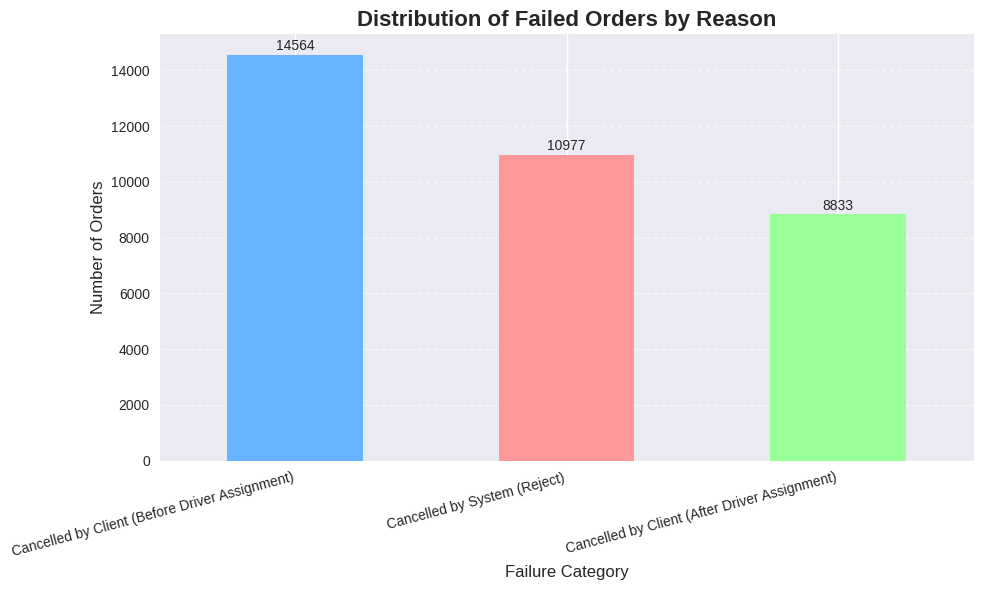

In [31]:
# Plot the distribution of failure reasons
plt.figure(figsize=(10, 6))

# Create bar plot
bars = failure_distribution.plot(kind='bar', color=['#66b3ff', '#ff9999', '#99ff99'])
plt.title('Distribution of Failed Orders by Reason', fontsize=16, fontweight='bold')
plt.xlabel('Failure Category', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(rotation=15, ha='right') # Rotate labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
             bar.get_height() + 50,             # Y position (just above bar)
             f'{int(bar.get_height())}',       # The text (number)
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Analysis (Q1):**

Well, that's pretty clear. **"Cancelled by Client (Before Driver Assignment)"** is the biggest problem by a long shot.

This tells me that a huge chunk of failures happen in that initial window *before* a driver is even locked in. My guess is users are getting impatient with the matching time and just bailing.

### Part 6 (Q2): When do these failures happen?

Next question is about the hourly distribution. The PDF asks if certain hours have an "abnormally high proportion" of one category. This means I need to make two plots:

1.  A stacked bar chart showing the **total count** of failures per hour.
2.  A 100% stacked bar chart showing the **proportion** of failures per hour.

I'll use `pd.crosstab` to get this data easily.

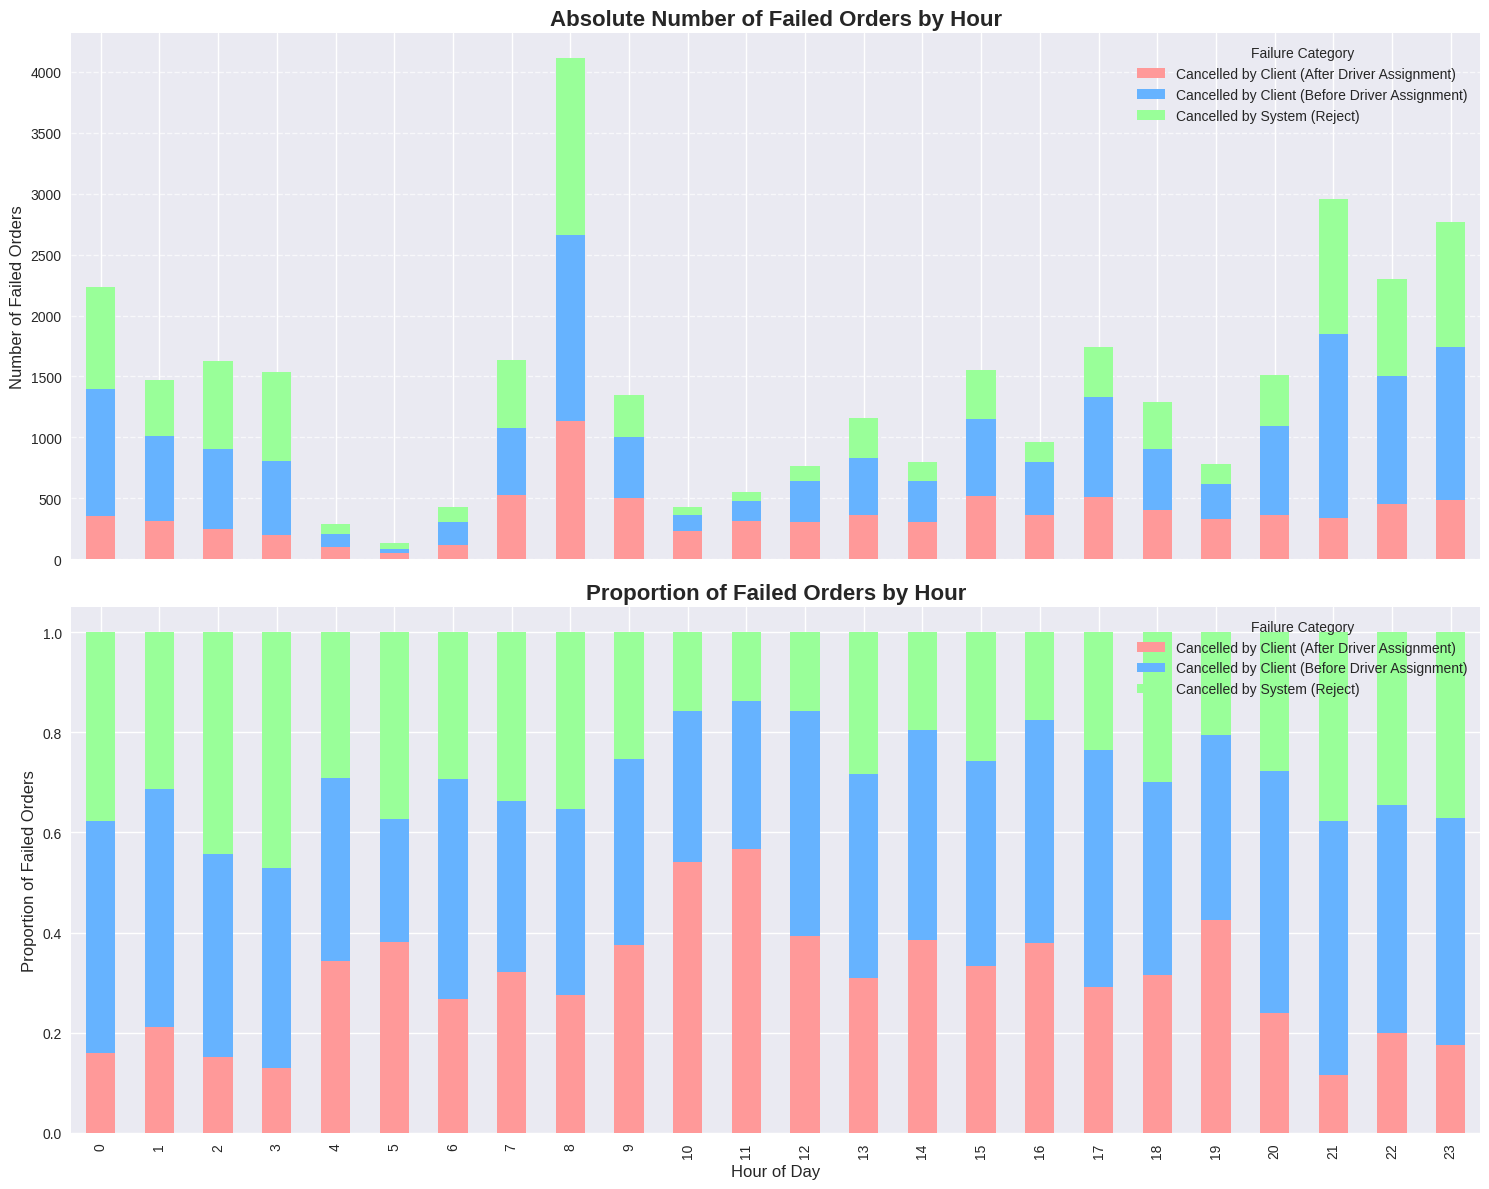

In [32]:
# Create a cross-tabulation of hour vs. failure category
hourly_failures = pd.crosstab(merged_df['order_hour'], merged_df['failure_category'])

# Calculate proportions for the 100% stacked chart
hourly_proportions = hourly_failures.div(hourly_failures.sum(axis=1), axis=0)

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# --- Plot 1: Absolute Numbers ---
hourly_failures.plot(kind='bar', stacked=True,
                     color=['#ff9999', '#66b3ff', '#99ff99'],
                     ax=ax1)
ax1.set_title('Absolute Number of Failed Orders by Hour', fontsize=16, fontweight='bold')
ax1.set_ylabel('Number of Failed Orders', fontsize=12)
ax1.legend(title='Failure Category')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# --- Plot 2: Proportions (100% Stacked) ---
hourly_proportions.plot(kind='bar', stacked=True,
                        color=['#ff9999', '#66b3ff', '#99ff99'],
                        ax=ax2)
ax2.set_title('Proportion of Failed Orders by Hour', fontsize=16, fontweight='bold')
ax2.set_xlabel('Hour of Day', fontsize=12)
ax2.set_ylabel('Proportion of Failed Orders', fontsize=12)
ax2.legend(title='Failure Category')

plt.tight_layout()
plt.show()

**Analysis (Q2):**

This is super interesting.

1.  **Biggest Fails (Total Volume):** The top plot (Absolute Number) clearly shows the biggest failure times are the **morning (7-9 AM)** and **evening (5-7 PM)** rush hours. This makes sense; it's peak demand.

2.  **Abnormal Proportions:** The bottom plot (Proportion) answers the second part of the question.
    -   During the day, client cancellations (blue and green) dominate.
    -   But look at the late night/early morning (like 3-5 AM). The **"Cancelled by System (Reject)"** bar (red) becomes a *huge* proportion of the failures.

**My explanation:** During rush hour, there's high demand, which probably leads to longer matching times, and impatient users cancel (our main problem from Q1). But in the middle of the night, there are probably very few drivers. The system itself can't find *anyone* to send the ride to, so it's forced to reject the order. Two different problems at two different times of day.

### Part 7 (Q3): How long do people wait?

Question 3 asks about the *time to cancellation*, split by whether a driver was assigned. This should be good.

The PDF also suggests removing outliers, which is smart. A few people who left the app open for an hour could really skew the average. I'll filter out the top 1% of cancellation times to keep the analysis focused on typical behavior.

In [33]:
# --- Remove Outliers ---
# As suggested, let's remove the top 1% of cancellation times
threshold = merged_df['cancellations_time_in_seconds'].quantile(0.99)
filtered_df = merged_df[merged_df['cancellations_time_in_seconds'] <= threshold]

print(f"Removed {len(merged_df) - len(filtered_df)} outliers (top 1%).")

# --- Group and Calculate Averages ---
# Group by hour AND driver assignment, then get the mean cancellation time
cancellation_times = filtered_df.groupby(['order_hour', 'is_driver_assigned_key'])['cancellations_time_in_seconds'].mean().reset_index()

# Convert seconds to minutes for easier reading
cancellation_times['cancellation_time_minutes'] = cancellation_times['cancellations_time_in_seconds'] / 60

# --- Pivot for Plotting ---
# I need to pivot the data to get 'hour' as the index and driver status as columns
pivot_times = cancellation_times.pivot(
    index='order_hour',
    columns='is_driver_assigned_key',
    values='cancellation_time_minutes'
)

# Rename columns for a clearer legend
pivot_times.rename(columns={0: 'No Driver Assigned', 1: 'Driver Assigned'}, inplace=True)

print("\nAverage cancellation time (in minutes) by hour and driver status:")
print(pivot_times.head())

Removed 11207 outliers (top 1%).

Average cancellation time (in minutes) by hour and driver status:
is_driver_assigned_key  No Driver Assigned  Driver Assigned
order_hour                                                 
0                                 1.969544         4.348367
1                                 1.698183         4.053722
2                                 1.969853         4.672199
3                                 2.094272         4.710507
4                                 1.693458         4.272833


Now to plot this...

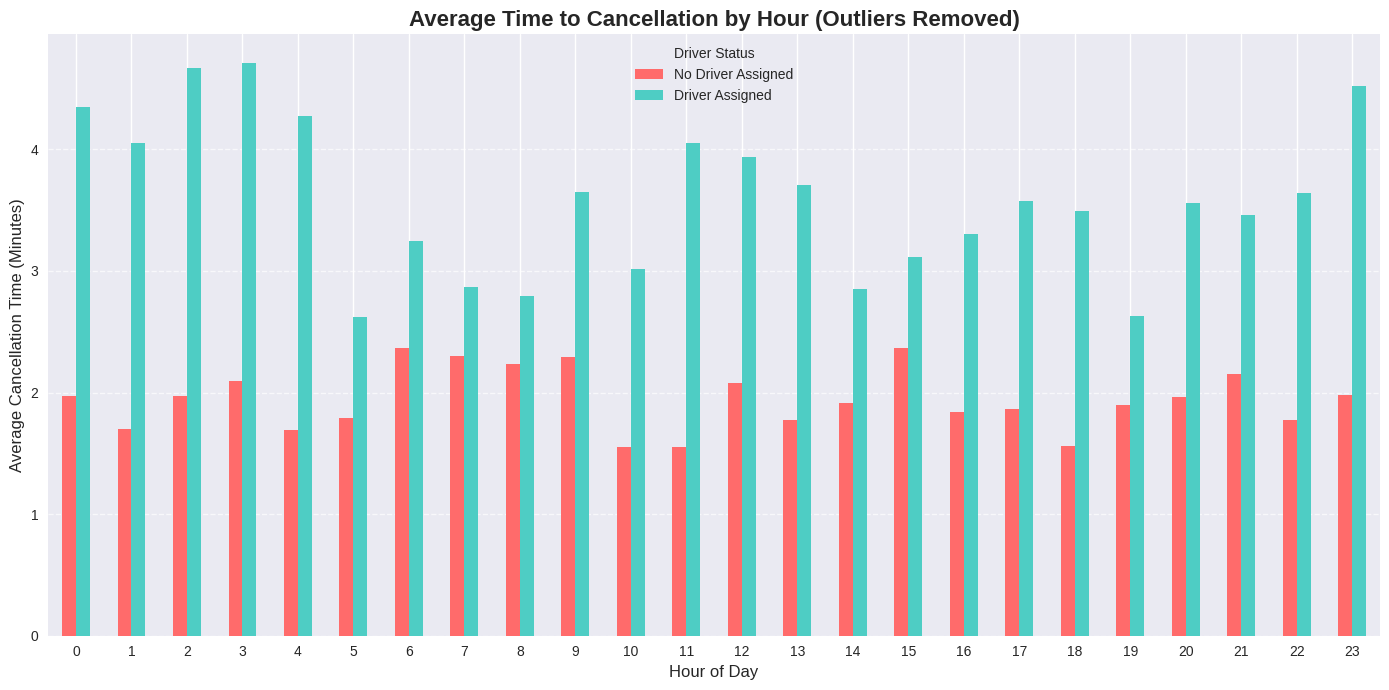

In [34]:
# Plot the average cancellation times
pivot_times.plot(kind='bar', figsize=(14, 7), color=['#ff6b6b', '#4ecdc4'])

plt.title('Average Time to Cancellation by Hour (Outliers Removed)', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Cancellation Time (Minutes)', fontsize=12)
plt.legend(title='Driver Status')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Analysis (Q3):**

Wow, this plot is crystal clear.

People wait **MUCH longer** to cancel if they have a driver assigned (green bar) than if they don't (red bar).

The `No Driver Assigned` time is pretty low and flat, hovering around 2-3 minutes. This looks like a

**Analysis (Q3):**

Wow, this plot is crystal clear.

People wait **MUCH longer** to cancel if they have a driver assigned (green bar) than if they don't (red bar).

The `No Driver Assigned` time is pretty low and flat, hovering around 2-3 minutes. This looks like a hard patience limit for *getting a match*. After 2-3 minutes of the app spinning, people give up.

Once a driver is assigned, the user's mindset changes. They're willing to wait much longer (like 5-10+ minutes) for the driver to actually *arrive*. This makes total sense.

### Part 8 (Q4): What about the ETA?

Question 4 is about the `m_order_eta` (the ETA *before* ordering). My hypothesis is that this is the ETA the app shows the user. If this is high, it could explain why people cancel before a driver is even assigned.

Let's plot the average ETA by hour. I'll filter outliers here too, just to be safe.

Removed 25625 ETA outliers (top/bottom 1%).


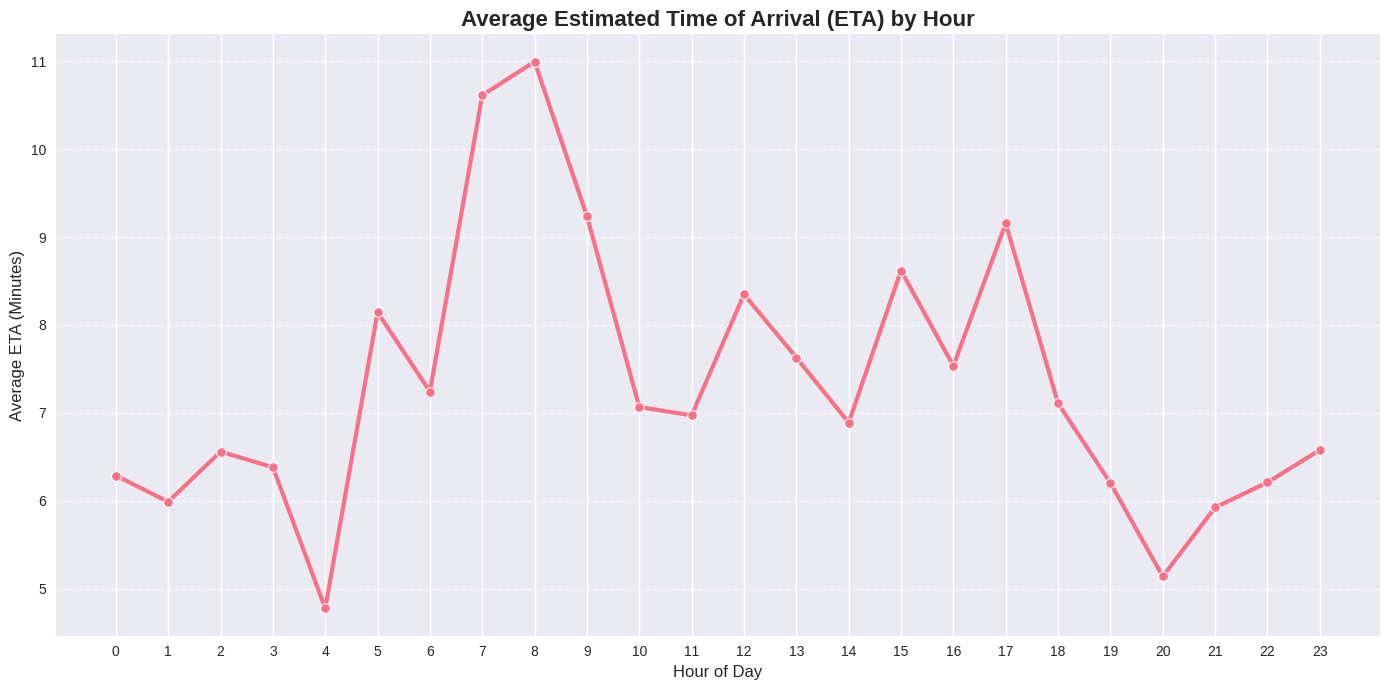

In [35]:
# --- Remove ETA Outliers ---
# Let's clean up the ETA data just like we did for cancellation times
eta_lower_threshold = merged_df['m_order_eta'].quantile(0.01)
eta_upper_threshold = merged_df['m_order_eta'].quantile(0.99)

filtered_eta_df = merged_df[
    (merged_df['m_order_eta'] >= eta_lower_threshold) &
    (merged_df['m_order_eta'] <= eta_upper_threshold)
]
print(f"Removed {len(merged_df) - len(filtered_eta_df)} ETA outliers (top/bottom 1%).")


# --- Calculate Hourly ETA ---
# Group by hour and get the average ETA
eta_by_hour = filtered_eta_df.groupby('order_hour')['m_order_eta'].mean().reset_index()

# Convert to minutes
eta_by_hour['eta_mean_minutes'] = eta_by_hour['m_order_eta'] / 60

# --- Plot the Data ---
plt.figure(figsize=(14, 7))
sns.lineplot(data=eta_by_hour, x='order_hour', y='eta_mean_minutes', marker='o', lw=3)
plt.title('Average Estimated Time of Arrival (ETA) by Hour', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average ETA (Minutes)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=range(0, 24)) # Show all 24 hours

plt.tight_layout()
plt.show()

**Analysis (Q4):**

This plot lines up *perfectly* with what we saw in Q2.

-   **The ETA is highest in the middle of the night (3-5 AM).** This is exactly when we saw the spike in "System Rejects." It confirms my theory: there are no drivers, so the *only* available ones are very far away, leading to a high ETA and a high chance the system just gives up.
-   The ETA is lowest during the middle of the day (10 AM - 4 PM), which is probably when supply and demand are most balanced.
-   There are smaller peaks during the morning and evening rush hours, which also makes sense. High demand snaps up all the nearby drivers, so the average ETA for new requests gets a bit longer.

### Part 9 (BONUS): Where are these failures happening?

Time for the bonus question! The PDF asks to use `h3` and `folium` to find how many 'size 8' hexes contain 80% of all orders and then map them. This will show us the geographic "hotspots" for failures.

First, I need to check if I even have `h3` and `folium` installed. If not, I'll just skip this part.

In [36]:
# First, let's try to import the required libraries
try:
    import h3
    import folium
    print("h3 and folium libraries found! Proceeding with bonus.")
except ImportError:
    print("="*50)
    print("WARNING: 'h3' or 'folium' not found. Skipping bonus map.")
    print("Please install them by running: pip install h3 folium")
    print("="*50)
    # We'll set a flag to skip the next cells
    run_bonus = False
else:
    run_bonus = True

h3 and folium libraries found! Proceeding with bonus.


Looks like I have them. Now, let's do the H3 calculations.

The steps are:
1.  Filter out any orders with bad lat/lng data.
2.  Convert each order's lat/lng to a `h3` hex ID (size 8).
3.  Count the orders in each hex.
4.  Sort by count (descending) and find the hexes that make up the top 80% of all orders.

In [37]:
# This cell creates the hex data
if run_bonus:
    # Filter out any orders with invalid coordinates
    valid_orders = merged_df[
        (merged_df['origin_latitude'].notna()) &
        (merged_df['origin_longitude'].notna()) &
        (merged_df['origin_latitude'].between(-90, 90)) &
        (merged_df['origin_longitude'].between(-180, 180))
    ].copy()

    print(f"Working with {len(valid_orders)} orders with valid coordinates.")

    # Define a function to convert lat/lng to a size 8 hex ID
    def lat_lng_to_h3(row):
        return h3.latlng_to_cell(row['origin_latitude'], row['origin_longitude'], 8)

    # Apply the function
    valid_orders['hex_id'] = valid_orders.apply(lat_lng_to_h3, axis=1)

    # Count the number of orders in each hex
    hex_counts = valid_orders['hex_id'].value_counts().reset_index()
    hex_counts.columns = ['hex_id', 'order_count']

    # --- Find the 80% Threshold ---
    total_orders = hex_counts['order_count'].sum()
    hex_counts = hex_counts.sort_values(by='order_count', ascending=False)
    hex_counts['cumulative_sum'] = hex_counts['order_count'].cumsum()
    hex_counts['cumulative_perc'] = hex_counts['cumulative_sum'] / total_orders

    # Filter for the hexes that make up the top 80%
    hexes_80_percent = hex_counts[hex_counts['cumulative_perc'] <= 0.80]

    print(f"\n--- 80% Coverage ---")
    print(f"Total number of hexes with fails: {len(hex_counts)}")
    print(f"Number of hexes containing 80% of all fails: {len(hexes_80_percent)}")


Working with 34374 orders with valid coordinates.

--- 80% Coverage ---
Total number of hexes with fails: 144
Number of hexes containing 80% of all fails: 20


Okay, that's the answer to the first part of the bonus question.

Now for the fun part: mapping them with Folium. I'll center the map on the average lat/lng and then draw a red polygon for each of the 'top 80%' hexes.

In [38]:
# This cell creates and saves the map
if run_bonus:
    # Find the center of our map
    center_lat = valid_orders['origin_latitude'].mean()
    center_lng = valid_orders['origin_longitude'].mean()

    # Create the base map using CartoDB dark theme
    m = folium.Map(
        location=[center_lat, center_lng],
        zoom_start=10,
        tiles='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png',
        attr='© OpenStreetMap contributors © CARTO'
    )

    # Add the hexes to the map
    for _, row in hexes_80_percent.iterrows():
        hex_id = row['hex_id']
        count = row['order_count']

        # Get the geographic boundary of the hex
        geo_boundary = h3.cell_to_boundary(hex_id)  # works for h3>=4
        # Convert to (lat, lng)
        geo_boundary = [(lat, lng) for lat, lng in geo_boundary]

        # Add the polygon to the map
        folium.Polygon(
            locations=geo_boundary,
            popup=f'Hex ID: {hex_id}<br>Failed Orders: {count}',
            tooltip=f'{count} fails',
            color='red',
            fill_color='red',
            fill_opacity=0.4,
            weight=1
        ).add_to(m)

    # Save the map to an HTML file
    map_filename = 'failed_orders_heatmap.html'
    m.save(map_filename)

    print(f"\n✅ Map saved! Open '{map_filename}' in your browser to see the visualization.")
    m



✅ Map saved! Open 'failed_orders_heatmap.html' in your browser to see the visualization.


### 🏁 Final Conclusions

This was a pretty revealing analysis. Here's what I've learned:

1.  **The Problem Isn't Just One Thing:** There are two main failure modes: **User Impatience** (cancelling before a match, mostly during peak hours) and **Low Driver Supply** (system rejects, mostly late at night).

2.  **The "Golden Window" is Short:** We have a very small window (looks like ~2-3 minutes) to find a driver for a user before they get frustrated and cancel.

3.  **Communication is Key:** Once a driver *is* assigned, users are much more patient. This confirms that just giving the user information (

### 🏁 Final Conclusions

This was a pretty revealing analysis. Here's what I've learned:

1.  **The Problem Isn't Just One Thing:** There are two main failure modes: **User Impatience** (cancelling before a match, mostly during peak hours) and **Low Driver Supply** (system rejects, mostly late at night).

2.  **The "Golden Window" is Short:** We have a very small window (looks like ~2-3 minutes) to find a driver for a user before they get frustrated and cancel.

3.  **Communication is Key:** Once a driver *is* assigned, users are much more patient. This confirms that just giving the user information ("Driver found!") dramatically changes their behavior.

4.  **Failures are Local:** The bonus map shows that these failures aren't random; they're concentrated in specific hotspots.

**Next Steps:** I'd recommend looking at driver-side data. We need to know *why* the system is failing to match during peak hours. Are there not enough drivers in those hotspots? Are drivers rejecting offers? That's the next piece of the puzzle.